## Importing necessary libraries 

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import glob
import tensorflow as tf
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import albumentations as alb
from pathlib import Path
import tensorflow as tf

## Randomly place waldo on backgrounds

In [2]:
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600

In [3]:
def resize_background(bg_path, target_width, target_height):
    with Image.open(bg_path) as bg:
        bg_width, bg_height = bg.size
#         Enlarge
        if bg_width < target_width or bg_height < target_height:
            resized_bg = bg.resize((target_width, target_height), Image.LANCZOS)
#             Reduce
        elif bg_width > target_width or bg_height > target_height:
            resized_bg = bg.resize((target_width, target_height), Image.ANTIALIAS)
        else:
            resized_bg = bg.copy()  # Copy to ensure we don't return a closed image
        return resized_bg

In [4]:
def place_waldo_on_bg(waldo_path, bg_image):
    # Ensure the background is in RGBA
    bg_image = bg_image.convert("RGBA")

    # Open the Waldo image (in PNG format)
    with Image.open(waldo_path) as waldo:
        waldo = waldo.convert("RGBA")  # Ensure Waldo is in RGBA mode 
        waldo_width, waldo_height = waldo.size
        bg_width, bg_height = bg_image.size
        
        # Scale Waldo 
        if waldo_width > bg_width or waldo_height > bg_height:
            factor = min((bg_width * .2) / waldo_width, (bg_height * .2) / waldo_height)
            waldo = waldo.resize((int(waldo_width * factor), int(waldo_height * factor)), Image.LANCZOS)
            waldo_width, waldo_height = waldo.size
        
        # Random location for Waldo
        max_width_position = bg_width - waldo_width
        max_height_position = bg_height - waldo_height
        position_width = random.randint(0, max_width_position)
        position_height = random.randint(0, max_height_position)
        
        bg_image.paste(waldo, (position_width, position_height), waldo)

        # Convert the result back to RGB to save in JPEG format
        bg_image = bg_image.convert("RGB")
        
        return bg_image

In [5]:
def send_img_to_directory(directory_path, image, file_name):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Check if the image has an alpha channel (RGBA)
    if image.mode == 'RGBA':
        # Create a white RGB background
        background = Image.new('RGB', image.size, (255, 255, 255))
        # Paste using alpha channel as mask
        background.paste(image, (0, 0), image)
        image = background

    file_path = os.path.join(directory_path, file_name)
    image.save(file_path, 'JPEG')

In [6]:
waldo_path = 'data/images/waldo.png'
waldo = Image.open(waldo_path)
background_paths = glob.glob('data/images/*.jpg') + glob.glob('data/images/*.jpeg')

for i, bg_path in enumerate(background_paths):
    resized_bg = resize_background(bg_path=bg_path, target_width=IMAGE_WIDTH, target_height=IMAGE_HEIGHT)
    background_with_waldo = place_waldo_on_bg(waldo_path=waldo_path, bg_image=resized_bg)
    file_name = f'bg{i+1}_with_waldo.jpg'
    send_img_to_directory(directory_path='data/created_images', image=background_with_waldo, file_name=file_name)

/var/folders/jk/524t5p750nl3f8pm6p6q2bv40000gn/T/ipykernel_28708/1179995627.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_bg = bg.resize((target_width, target_height), Image.ANTIALIAS)


## Label the waldo for each generated picture using labelme

In [19]:
# !labelme 

## Make the image file into array

In [8]:
images = tf.data.Dataset.list_files('data/created_images/*.jpg', shuffle=False)

In [9]:
def load_image(file_path):
    byte_img = tf.io.read_file(file_path) # byte coded image
    img = tf.io.decode_jpeg(byte_img)  # decote it
    return img

In [10]:
images = images.map(load_image) # apply load image function for each value in the dataset. 

In [11]:
# batch returns the number of the parameter. In this case, it returns 4 images. 
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

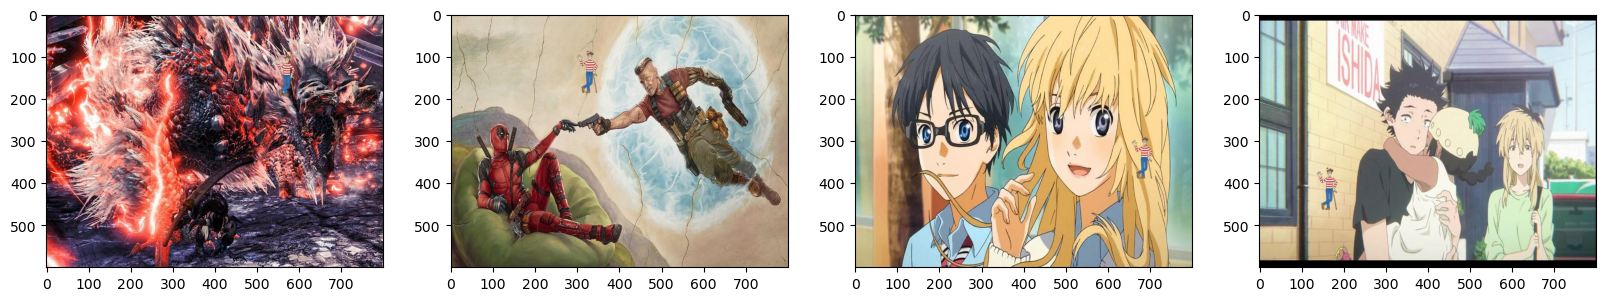

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## Splitting image and json file into train, test and validation

In [14]:
images_dir = 'data/created_images'
json_dir = 'data/processed_img_info'

image_paths = []
json_paths = []

# Load Images and corresponding Json file.
for image_file in os.listdir(images_dir):
    if image_file.endswith('.jpg'):
        image_path = os.path.join(images_dir, image_file)
        json_file = image_file.replace('.jpg', '.json')
        json_path = os.path.join(json_dir, json_file)
        
        if os.path.exists(json_path):
            image_paths.append(image_path)
            json_paths.append(json_path)
            
# Split data
train_img_paths, test_val_img_paths, train_json_paths, test_val_json_paths = train_test_split(image_paths, json_paths, test_size=0.3, random_state=42)
test_img_paths, val_img_paths, test_json_path, val_json_path = train_test_split(test_val_img_paths, test_val_json_paths, test_size=0.5, random_state=42)

# Copy files into respective directories
def copy_files(image_paths, json_paths, target_img_dir, target_json_dir):
    os.makedirs(target_img_dir, exist_ok=True)
    os.makedirs(target_json_dir, exist_ok=True)
    
    for img_path, json_path in zip(image_paths, json_paths):
        shutil.copy(img_path, target_img_dir)
        shutil.copy(json_path, target_json_dir)

In [15]:
copy_files(train_img_paths, train_json_paths, 'data/train/images', 'data/train/labels')
copy_files(test_img_paths, test_json_path, 'data/test/images', 'data/test/labels')
copy_files(val_img_paths, val_json_path, 'data/validation/images', 'data/validation/labels')

## Augment images to increase the size of train, test, and validation dataset.

In [16]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.2)],
                        bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [24]:
def load_label(label_path):
    if label_path.exists():
        with label_path.open('r') as file:
            label = json.load(file)
            coords = [coord for point in label['shapes'][0]['points'] for coord in point]
            return list(np.divide(coords, [IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_HEIGHT]))

In [27]:
def process_image(image_path, label_path, partition):
    img = cv2.imread(str(image_path))
    coords = load_label(label_path)

    for x in range(60):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=['waldo'])
        augmented_image_path = Path('aug_data', partition, 'images', f'{image_path.stem}.{x}.jpg')
        cv2.imwrite(str(augmented_image_path), augmented['image'])

        annotation = {'image': image_path.name, 'bbox': [0,0,0,0], 'class': 0}

        if label_path.exists():
            if augmented['bboxes']:
                annotation['bbox'] = augmented['bboxes'][0]
                annotation['class'] = 1

        with open(Path('aug_data', partition, 'labels', f'{image_path.stem}.{x}.json'), 'w') as file:
            json.dump(annotation, file)

In [28]:
for partition in ['train', 'test', 'validation']:
    data_dir = Path('data', partition)
    images_dir = data_dir / 'images'
    labels_dir = data_dir / 'labels'

    for image_path in images_dir.iterdir():
        if image_path.is_file():
            label_path = labels_dir / f'{image_path.stem}.json'
            try:
                process_image(image_path, label_path, partition)
            except Exception as e:
                print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type


## Load augmented images in Tensorflow Dataset

In [29]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [120, 120])
    image = image / 255.0
    return image

In [30]:
def create_dataset(image_dir):
    dataset = tf.data.Dataset.list_files(image_dir + '/*.jpg', shuffle=False)
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

In [31]:
train_images = create_dataset('aug_data/train/images')
test_images = create_dataset('aug_data/test/images')
val_images = create_dataset('aug_data/validation/images')

## Prepare Labels

In [32]:
def load_labels(label_path):
#   Read json file
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    
    return [label['class']], label['bbox']

In [33]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))